In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_selection import f_classif, SelectKBest, SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, silhouette_score, homogeneity_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [4]:
data.shape

(12146, 30703)

In [6]:
klase = set(data.iloc[:,1].values.ravel())
klase

{'BC', 'DC', 'MC', 'NK', 'TC'}

In [7]:
X = data.iloc[:, 4:-1]

In [9]:
X.shape

(12146, 30698)

In [10]:
variances = X.var()
print(variances)
print(f'Mean: {variances.mean()}')
print(f'Median: {variances.median()}')
print(f'Min: {variances.min()}')
print(f'Max: {variances.max()}')

hg38_ZFP41         0.002137
hg38_ASF1A         0.074015
hg38_TMEM39A       0.035085
hg38_OR2M7         0.000000
hg38_CCT7          0.171953
                     ...   
hg38_TPH2          0.000905
hg38_LINC00626     0.000000
hg38_LRRC29        0.003039
hg38_AC073333.8    0.000082
hg38_ZFP36         0.669135
Length: 30698, dtype: float64
Mean: 0.038051841525538956
Median: 0.0016440565950823246
Min: 0.0
Max: 2.587398569226056


In [11]:
variances.shape

(30698,)

In [12]:
vt = VarianceThreshold(threshold=0.05)

In [13]:
X_vt_1 = vt.fit_transform(X)

In [14]:
X_vt_1.shape

(12146, 5776)

In [15]:
X_vt_1_df = pd.DataFrame(data=X_vt_1)
X_vt_1_df.to_csv('X_vt_1.csv', index=False)

In [16]:
X_vt_1.T.var().min()

0.36296961382541365

In [17]:
pca = PCA()
X_vt_1_pca = pca.fit_transform(X_vt_1)

In [18]:
pca.explained_variance_ratio_[:50].sum()

0.17930960350652775

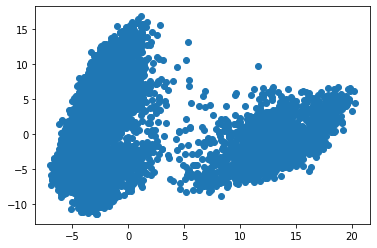

In [19]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1])

In [20]:
X_vt_1_graph = kneighbors_graph(
    X_vt_1, 
    n_neighbors=150, 
    mode='distance', 
    metric='cosine',
    n_jobs=-1
)

In [21]:
X_vt_1_graph_map = kneighbors_graph(
    X_vt_1, 
    n_neighbors=150, 
    mode='connectivity', 
    metric='cosine',
    n_jobs=-1
)

In [22]:
X_vt_1_graph_arr = X_vt_1_graph.toarray()
X_vt_1_graph_map_arr = X_vt_1_graph_map.toarray()
X_vt_1_graph_full = X_vt_1_graph_arr

X_vt_1_graph_full = 1.0 / (1.0 + X_vt_1_graph_arr)

In [23]:
X_vt_1_graph_full[X_vt_1_graph_map_arr == 0] = 0

In [24]:
sc = SpectralClustering(
    n_clusters=5, 
    affinity='precomputed', 
    n_components=2
)
sc.fit(X_vt_1_graph_full)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


SpectralClustering(affinity='precomputed', n_clusters=5, n_components=2)

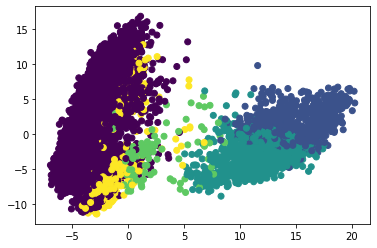

In [26]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1], c=sc.labels_)

In [27]:
# Silueta
silhouette_score(X_vt_1, labels=sc.labels_, metric='cosine')

0.02274162361410731

In [28]:
ac = AgglomerativeClustering(
    n_clusters=15, 
    affinity='cosine', 
    linkage='average'
)
fitted_model = ac.fit(X_vt_1)

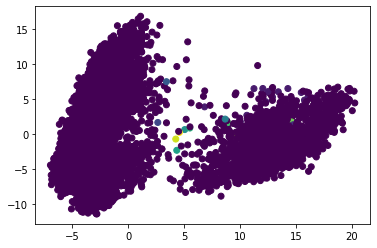

In [29]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1], c=ac.labels_)

In [30]:
silhouette_score(X_vt_1, labels=ac.labels_, metric='cosine')

0.3696722189017715

In [31]:
ac = AgglomerativeClustering(
    n_clusters=15, 
    affinity='euclidean', 
    linkage='ward'
)
fitted_model = ac.fit(X_vt_1)

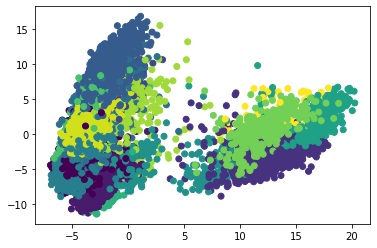

In [32]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1], c=ac.labels_)

In [33]:
silhouette_score(X_vt_1, labels=ac.labels_, metric='cosine')

-0.013054823780136874

In [34]:
def kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    return kmeans.predict(data)


In [35]:
labels = kmeans(X_vt_1, 5)

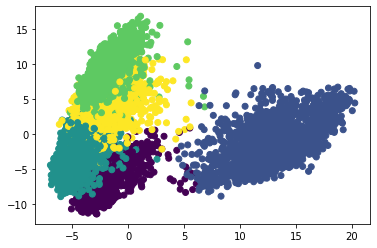

In [38]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1], c=labels)

In [36]:
silhouette_score(X_vt_1, labels)

0.012386806591786976